In [1]:
import numpy as np
import copy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

# Synthetic Datapoints to test the EM algorithm while building

Just used for testing purposes

In [ ]:
n=100 #number of points
d=2 #dimension of each point
k=2 #clusters

#randomly generate k number of  d-dimensional means
mus=np.random.random((k,d))*20-10 

#Data Generation
X=[]
for i in range(n):
    for j in range(k):
        X.append([mean+np.random.randn() for mean in mus[j]])
#we have our dataset, where each point is a d+1 dimensional tuple where the last position represents its class 

X = np.asarray(X)

# EM Algorithm

In [2]:
def EM(X,k):

    """Input 
    - np.array((n,d)), an nxd matrix of data points
    - n is the number of points
    - d is the dimension
    - k is the number of output cluster
    
    Output 
    - W - Posterior probability matrix (kxn)
    - new_mus - kxd matrix of means for each cluster
    - new_cov (kxdxd) -  a list of length k, where each element is a covariance matrix of dxd dimension.
    - t: Number of iterations"""

    #dimension of the dataset
    d = X.shape[1]

    #number of points in the dataset
    n = X.shape[0]

    '''initialising means ---------------------------------'''
    # random means
    # old_mus = np.array([np.random.rand(d) for _ in range(k)])

    # select random datapoints from data as initial means
    random_rows = np.random.choice(X.shape[0], size=k, replace=False)
    old_mus = copy.deepcopy(X[random_rows, :])

    # choose means from unifrom random between 'a' and 'b' 
    # old_mus = np.random.random((k,d))*20-10 
    # old_mus = np.random.random((k,d))*np.max(X)-np.min(X)


    new_mus = copy.deepcopy(old_mus)
    '''-------------------------------------------------------'''


    '''initalising covariance matrices-------------------------'''
    #identity matrices of dxd dimension as covariance matrices
    old_cov = np.asarray([np.eye(d) for _ in range(k)])
    new_cov = copy.deepcopy(old_cov)
    '''-------------------------------------------------------'''

    '''initialising priors-------------------------------------'''
    #priors are 1/k where k is the number of classes
    old_priors = np.full((k),1/k)
    new_priors = copy.deepcopy(old_priors)
    '''-------------------------------------------------------'''

    #stopping condition
    eps = 1e-02

    #starting time
    t = 0

    #aritifcal condition to enter the loop
    obt_eps = 1

    while (obt_eps > eps) or (t==0):
        t += 1

        '''Begin Expectation step---------------------------------------------------------'''
        #get the W matrix
        #unnormalised
        # W_temp = copy.deepcopy(tabulate(list(range(n)),list(range(k)),w_mat))
        # W_temp = np.array(list(map(w_mat, * np.meshgrid(list(range(n)), list(range(k))))))
        W_temp = np.zeros((k,n),dtype=float)
        for j in range(k):
            W_temp[j,:]= multivariate_normal.pdf(X,mean=new_mus[j],cov=new_cov[j],allow_singular=True) * new_priors[j]

        temp = copy.deepcopy(W_temp)
        #normalised
        W = copy.deepcopy(temp/temp.sum(axis=0))

        #it so happens that sometime, the probability of a point being assinged to any of the cluster is 0.
        #this is probably an artefact of multivariate.normal.pdf giving very small values 
        # and the 64 bit precision of the computer rounding stuff off to 0 or nan. 
        #When this happens, this part of the assigns the point to any of the clusters with equal probability.
        if np.isfinite(W).all():
            pass
        else:
            W_temp_where = np.where(temp.sum(axis=0)==0.0)
            for ii in W_temp_where:
                W[:,ii] = 1/k
        '''End Expectation step------------------------------------------------------------'''

        #get sum of W for each cluster
        temp = copy.deepcopy(W)
        sum_w = copy.deepcopy(temp.sum(axis=1))

        '''Begin Maximization step---------------------------------------------------------'''
        # re-estimate means
        old_mus = copy.deepcopy(new_mus)
        #unnormalised
        new_mus_temp = copy.deepcopy(W @ X)
        temp = copy.deepcopy(new_mus_temp)
        #normalised
        new_mus = copy.deepcopy(temp/sum_w[:,None])

        # re-estimate covariance
        old_cov = copy.deepcopy(new_cov)
        #unnormalised
        # new_cov_temp = copy.deepcopy([cov_loop(n,a) for a in range(k)])
        # temp = copy.deepcopy(new_cov_temp)
        #normalised
        # new_cov = copy.deepcopy([temp[a]/sum_w[a] for a in range(k)])
        new_cov = [
                    np.sum(
                            [
                                W[i,j]/(sum_w[i])*
                                (
                                    (np.expand_dims(X[j]-new_mus[i], axis=0).T) @ 
                                    np.expand_dims(X[j]-new_mus[i], axis=0)
                                ) 
                                for j in range(n)
                            ],axis=0
                        ) 
                        for i in range(k)
                     ]
        # new_cov = copy.deepcopy([cov_loop(n,a) for a in range(k)])



        # re-estimate priors
        old_priors = copy.deepcopy(new_priors)
        new_priors = copy.deepcopy(sum_w/n)
        '''End Maximization step---------------------------------------------------------'''

        obt_eps = np.sum([np.linalg.norm(new_mus[a]-old_mus[a]) for a in range(k)])
        print(obt_eps)
    # print("final", t,n,k,d,new_mus) 
    return W,new_mus,new_cov,t

def error_analysis(posterior_matrix,\
                    obtained_cluster_means,\
                    actual_means,\
                    df):
    
    """
    Input -     
    posterior_matrix - Posterior probability matrix (kxn)
    obtained_cluster_means - kxd matrix of means for each cluster obtained from the EM algorithm
    actual_means - kxd matrix of means for each cluster obtained from ground truth data
    df - dataframe where rows represent points and columns represent dimension. 
        The last columnd of the data frame is the ground truth label for that point

    Output - error for each cluster.
    """
    #creating a final array from the dataframe
    posterior = pd.DataFrame(posterior_matrix)

    #hard assignment. Each point is assigned to a cluster which has the maxiumum value of P(C|X)
    clustered_points = posterior.idxmax().to_dict()

    #ground truth from data
    ground_truth_means = copy.deepcopy(actual_means)

    #dictionary which maps the k cluster (means) to 2 clusters (since the ground truth only has two clusters)
    assignment_of_means_to_clusters = {}
    for i,each_cluster in enumerate(obtained_cluster_means):
        #measure eucledian distance to each of the ground truth clusters from the kth cluster and 
        #assign the cluster label to the ground truth cluster closer to it
        if np.linalg.norm(ground_truth_means[0]-each_cluster) > np.linalg.norm(ground_truth_means[1]-each_cluster):
            assignment_of_means_to_clusters[i] = 1
        else:
            assignment_of_means_to_clusters[i] = 0

    # now that k mean labels have been mapped to two clusters, 
    # map the points of each of the obtained clusters to one of the two ground truth cluster. 
    # if point 1 is in the 4th cluster (obtained from EM algo) 
    # and the 4th cluster has been mapped to cluster X of the ground truth data,
    # then point 1 now belongs to cluster X
    final_assignment_of_points = {k:assignment_of_means_to_clusters[v] for k,v in clustered_points.items()}

    #for ringnorm, 0 label means the cluster 
    # with ground truth means 0 (of d dimension) and cov (4*identity) of 20x20dimension
    # 1 label means the cluster with ground truth means 2/sqrt(20) (of d-dimension) and cov identity of 20x20dimension

    ground_truth_assignment_of_points = df[len(actual_means[0])].to_dict()

    error_df = pd.DataFrame()
    error_df['assigned'] = final_assignment_of_points.values()
    error_df['ground_truth'] = ground_truth_assignment_of_points.values()


    error_0 = error_df[error_df['ground_truth'] == 0]
    #proportion of points which should be assigned to cluster 0 but were assigned to cluster 1 instead
    error_01 = (len(error_0[error_0['assigned']==1])/len(error_df))

    error_1 = error_df[error_df['ground_truth'] == 1]
    #proportion of points which should be assigned to cluster 1 but were assigned to cluster 0 instead
    error_10 = len(error_1[error_1['assigned']==0])/len(error_df)

    return error_01,error_10


## Initialising Each Gaussian
The mean of each gaussian (cluster), initially, is picked to be the a random data point from the given data.  
The initial covariance of each cluster is set to be identity dxd matrix

## Breaking ties

During hard assignment, if a point is equally likely to be in any of the clusters, then it is assigned randomly to one of the clusters. 

## Stopping criteria

I have used the following - If the L2 norm of means between runs doesn't change by more than 10^-2, then the program terminates.   
I've also tested with smaller values (up till 10^-7). I decided 10^-2 is a good tradeoff when looking at time it takes to converge vs error.  

An additional stopping condition could have been the number of iterations. Using this, we could keep a L2 norm threshold (10^-7) but force the program to terminate when it reaches a threshold number of iterations.

## Combining Clusters

Clusters have been combined using the protocol described in the assignment. Checking Euclidean distance between mean of obtained cluster and the ground truth cluster means.



# Ringnorm analysis

In [3]:
# Loading data
# \s+ since dataset has one or more white spaces
df = pd.read_csv("Dataset.data",sep='\s+',header=None)

X = df.to_numpy()
X = X[:,:-1]

mus = np.asarray(
    [ [0]*X.shape[1],
        [2/np.sqrt(20)]*X.shape[1]
        ]
)

In [ ]:
#Run the EM algorithm 20 times for each k value. 
# This takes time. I have run it on the school server and attached the pickle files for proof
posteriors,output_mus,output_covs,iterations = {},{},{},{}

for k in [2,3,4,5]:
    data = {}
    for e in range(20):
        print(f"k={k},e={e}")
        p,m,c,i = EM(X,k)
        posteriors[e] = p
        output_mus[e] = m
        output_covs[e] = c
        iterations[e] = i
    data['posteriors'] = posteriors
    data['output_mus'] = output_mus
    data['output_covs'] = output_covs
    data['iterations'] = iterations
    with open(f"ringnorm{k}.pkl",'wb') as f:
        pkl.dump(data,f)
        

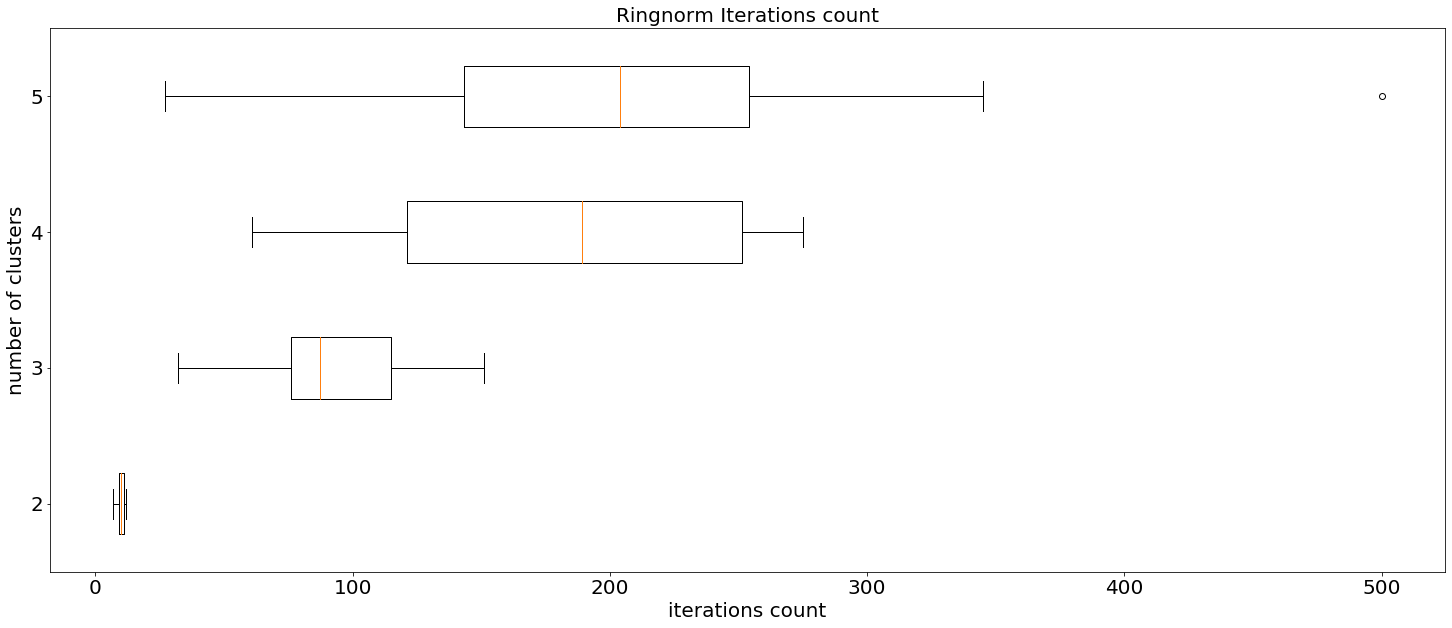

In [5]:
#Iterations count whisker plot for Ringnorm data
data = []
for k in [2,3,4,5]:
    with open(f"ringnorm{k}.pkl",'rb') as f:
        data.append(list(pkl.load(f)['iterations'].values()))
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('iterations count',size=20)
plt.ylabel('number of clusters',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Ringnorm Iterations count",size=20)

plt.rcParams["figure.figsize"] = (25,10)


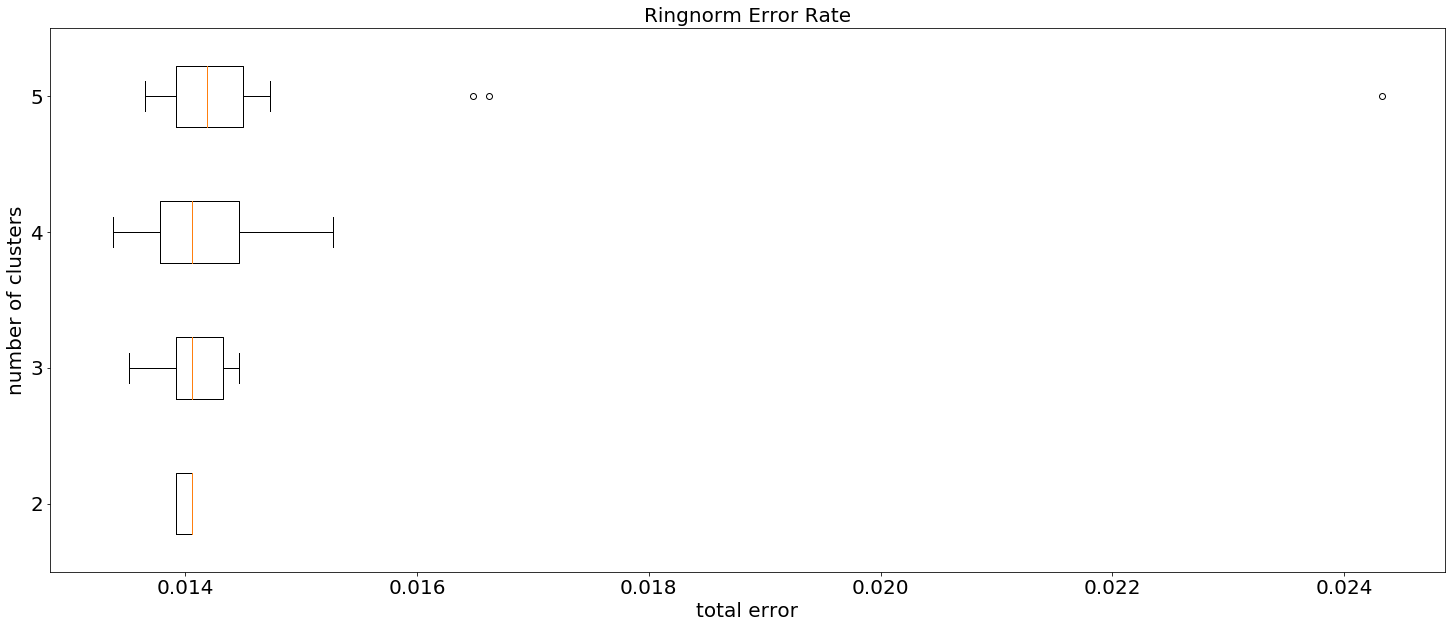

In [6]:
#Error rate whisker plot for Ringnorm data
total_error = {}
for k in [2,3,4,5]:
    total_error[k] = []
    with open(f"ringnorm{k}.pkl",'rb') as f:
       data = pkl.load(f)
    for e in range(20):
        error01,error10 = error_analysis(data['posteriors'][e],data['output_mus'][e],mus,df)
        total_error[k].append(error01+error10)

data = [total_error[k] for k in [2,3,4,5]]
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('total error',size=20)
plt.ylabel('number of clusters',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Ringnorm Error Rate",size=20)

plt.rcParams["figure.figsize"] = (25,9)

# Ionosphere Analysis

In [7]:
#\s+ since dataset has one or more white spaces
df = pd.read_csv("ionosphere.data",header=None)


In [8]:
#data points as a nxd matrix, mean of the good class and the bad class
X = df[list(range(34))].to_numpy()

mean_g = [i/len(df[df[34]=='g']) for i in df[df[34]=='g'].sum(axis=0).to_list()[:-1]]
mean_b = [i/len(df[df[34]=='b']) for i in df[df[34]=='b'].sum(axis=0).to_list()[:-1]]

mus = np.array([mean_g,mean_b])

In [ ]:
#Run the EM algorithm 20 times for each k value. 
# This takes time. I have run it on the school server and attached the pickle files for proof
posteriors,output_mus,output_covs,iterations = {},{},{},{}

for k in [2,3,4,5]:
    data = {}
    for e in range(20):
        print(f"k={k},e={e}")
        p,m,c,i = EM(X,k)
        posteriors[e] = p
        output_mus[e] = m
        output_covs[e] = c
        iterations[e] = i
    data['posteriors'] = posteriors
    data['output_mus'] = output_mus
    data['output_covs'] = output_covs
    data['iterations'] = iterations
    with open(f"Ionsophere{k}.pkl",'wb') as f:
        pkl.dump(data,f)
        

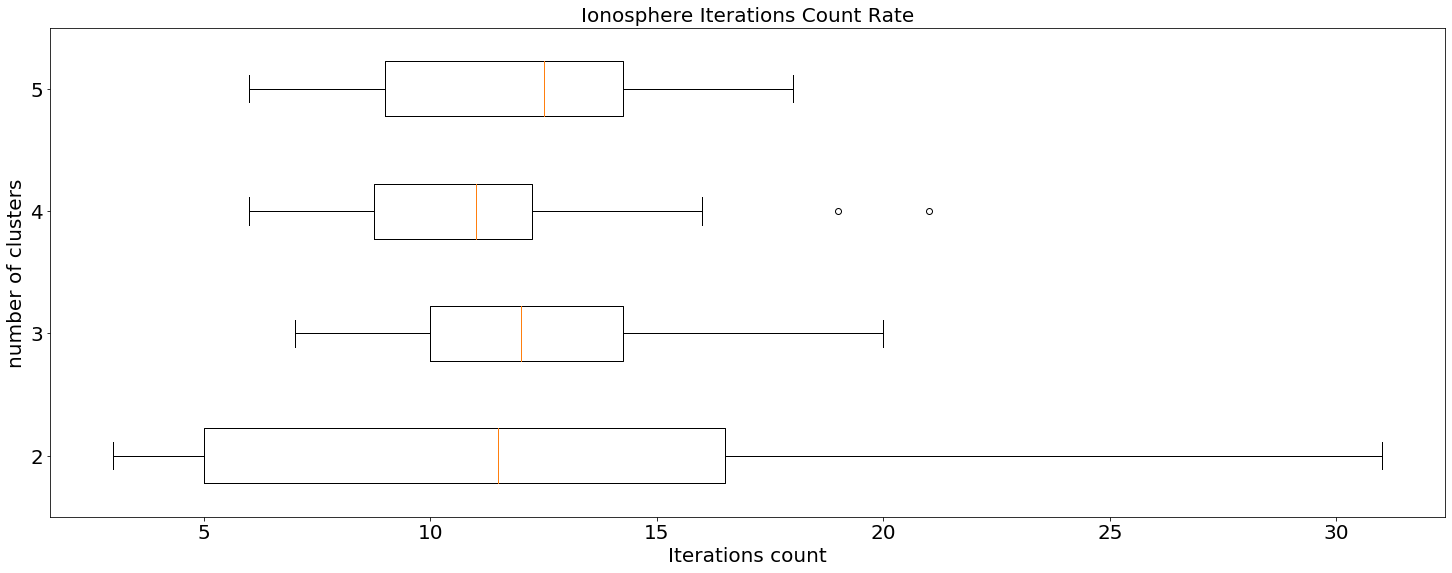

In [9]:
#Iterations count whisker plot for Ionosphere data
data = []
for k in [2,3,4,5]:
    with open(f"Ionosphere{k}.pkl",'rb') as f:
        data.append(list(pkl.load(f)['iterations'].values()))
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('Iterations count',size=20)
plt.ylabel('number of clusters',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Ionosphere Iterations Count Rate",size=20)

plt.rcParams["figure.figsize"] = (25,9)

2
3
4
5


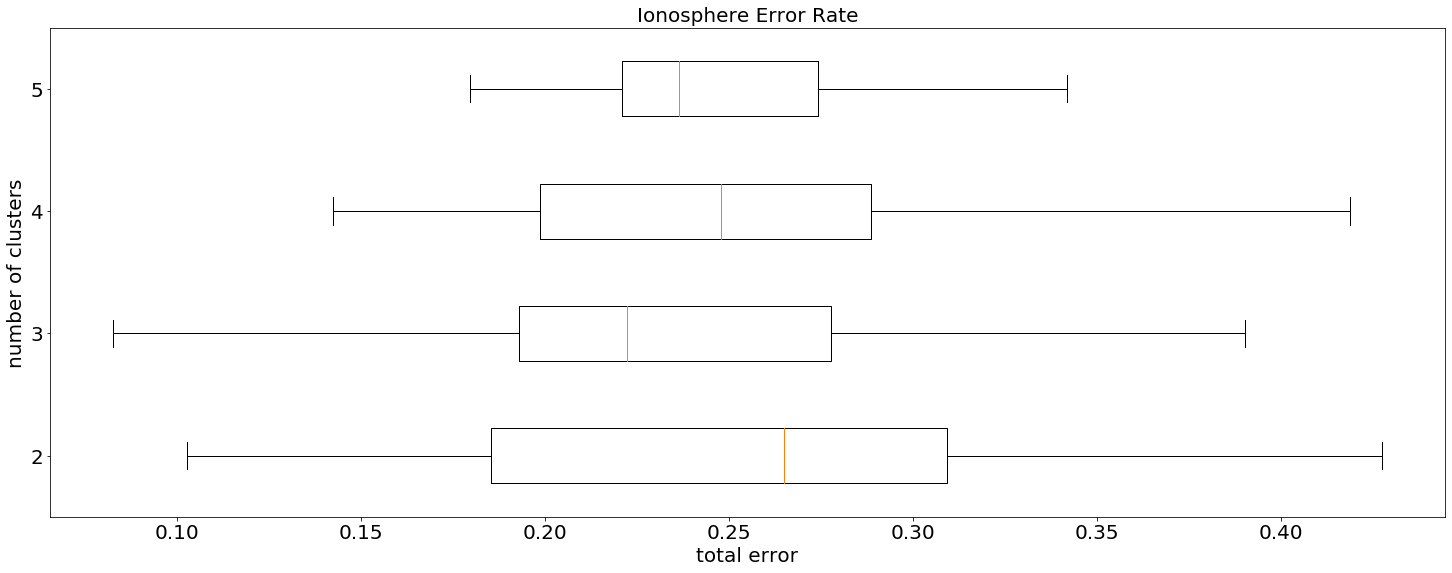

In [10]:
#Error rate whisker plot for Ionosphere data
df[df[34]=='g']=0
df[df[34]=='b']=1
total_error = {}
for k in [2,3,4,5]:
    print(k)
    total_error[k] = []
    with open(f"Ionosphere{k}.pkl",'rb') as f:
       data = pkl.load(f)
    for e in range(20):
        error_01,error_10 = error_analysis(data['posteriors'][e],data['output_mus'][e],mus,df)
        total_error[k].append(error_01+error_10)

data = [total_error[k] for k in [2,3,4,5]]
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('total error',size=20)
plt.ylabel('number of clusters',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Ionosphere Error Rate",size=20)

plt.rcParams["figure.figsize"] = (25,9)

### Overall, it looks like EM of Ionosphere data takes smaller number of iterations to converge when compared to the Ringnorm Data.
### However, the error on Ringnorm data (synthetic data, easier to cluster) is much smaller than the Ionosphere data (real world data, harder to cluster)


### 3.1 Given a text $D$ and a pattern P, describe an $\Omega(d+p)$ time method for finding the longest prefix of $P$ that is a substring of $D$. The lengths of $D$ and $P$ are $d$ and $p$, respectively.


Treat each prefix of the give pattern as a word (of length $l$, where 0<l<p) and use the KMP algorithm to find if the prefix (word) exists as a substring of D. The KMP algorithm is a $O(l+d)$ 
Do this for all prefixes of the given pattern starting from the largest prefix (so l can take values ranging between p to 1). Therefore total running time is $O(p+d) + O(p-1+d)+...O(1+d)$

In the best case, the largest prefix of pattern $P (l=p)$, is the longest prefix which is a substring of D. This would eliminate the need to run KMP for smaller $l's$). Thus best case running time is $\Omega(p+d)$

### 3.2 $X$, $Y$, and $Z$ are three arrays and each has $m$ elements. For an arbitrary integer $t$, describe $O(m^2logm)$-time algorithm to determine if there exist numbers, $x$ in $X$, $y$ in $Y$, and $z$ in $Z$, such that $t = x+y+z$.

All arrays have the same number of elements.   


Prepocessing step - Sort any one of the arrays. Say Z. This can be done in O(nlogn) time using merge sort or heap sort.

```
For each element x in X,
    For each element y in Y
        Perform a binary search for the element t - (x+y) in Z
            return True if found
            else return False
```

Given there are two for loops $(O(m^2))$ and a binary search $(O(logm))$ nested in it, the running time of this algorithm is $O(m^2logm)$

### 3.3 Describe an efficient algorithm for deleting a string (length s) from a compressed trie and analyze its running time.

1. Start from the root of the compressed trie
2. Traverse down the compressed trie in the DFS manner. DFS because consecutive elements of the string will be stored in as children of a node rather than siblings of the node.
3. If the string finishes matching on an internal node of the compressed trie, then return Failure since such an internal node cannot be deleted (this is because it might be a part of some other string)
4. If the string ends on leaf node which has only one element in it, delete this node along with all ancestral nodes with just one key in them. The string deletion on the compressed trie is complete.
5. If the string ends on leaf node which has more than one element in it, then return Failure since an this node cannot be deleted. It might be used by some other string. 
6. If there is no path which matches the string, then the string is not present in the compressed trie. Return Failure


Given that I've chosen to traverse the tree via DFS, the running time of the algorithm is - 
#### O(the depth of the number of nodes needed to represent the string in the compressed trie)~O(s)

1. Perhaps a more efficient way to do this is a bottom up manner where matching of string to the compressed trie starts from the leaf nodes and the last element of the string. In this case, it is better to check all the leaf nodes first!
2. If none of the leaf nodes contain the last element of the string, return Failure since this would either imply that the string is not present in the compressed trie or that the last element of the string is a an internal node (which cant be deleted since it is may belong to some other string)
If the node which 
3. Once all leaf nodes are processed, either we can continue traversing the compressed tie in the bottom up fashion or we can take the top down appraoch elaborated above.
4. If we continue in the bottom up manner, then the same rules as above follow. Internal nodes can never be deleted and since we are traversing it in the bottom up fashion, upon complete matching of the string, we need to check if the children (as opposed to ancesrots in the top down approach) of the node we are on has more than one key in it. If any of the node or its children have more than one key in it, return Failure. Although the worst case is the same as the top down approach, the best case running time is $\Omega$(number of leaf nodes)
